### Preliminaries

In [1]:
# Preliminaries to setup the notebook.  
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import numerical libraries.  
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.model_selection import ShuffleSplit,cross_val_score
from sklearn.model_selection import GridSearchCV

In [2]:
# Import the file I wrote to load the data from the tab-delimited text files.  
import dream
import loading
import scoring
import fit2

In [3]:
# Load the perceptual descriptors data.  
perceptual_headers, perceptual_obs_data = loading.load_perceptual_data('training')
loading.format_leaderboard_perceptual_data()
# Show the perceptual metadata types and perceptual descriptor names.
print(perceptual_headers)

['Compound Identifier', 'Odor', 'Replicate', 'Intensity', 'Dilution', 'subject #', 'INTENSITY/STRENGTH', 'VALENCE/PLEASANTNESS', 'BAKERY', 'SWEET', 'FRUIT', 'FISH', 'GARLIC', 'SPICES', 'COLD', 'SOUR', 'BURNT', 'ACID', 'WARM', 'MUSKY', 'SWEATY', 'AMMONIA/URINOUS', 'DECAYED', 'WOOD', 'GRASS', 'FLOWER', 'CHEMICAL']


In [4]:
# Show the metadata and perceptual descriptor values for the first compound.
print(perceptual_obs_data[1])

['126', '4-Hydroxybenzaldehyde', False, 'high', '1/10', '1', 37, 60, 0, 72, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [5]:
num_descriptors = len(perceptual_headers[6:])
num_subjects = 49
print('There are %d different perceptual descriptors and %d different subjects' % (num_descriptors,num_subjects))

There are 21 different perceptual descriptors and 49 different subjects


In [6]:
# Load the molecular descriptors data.  
molecular_headers, molecular_data = loading.load_molecular_data()
print("First ten molecular descriptor types are %s" % molecular_headers[:10])
print("First ten descriptor values for the first compound are %s" % molecular_data[0][:10])
total_size = len(set([int(row[0]) for row in molecular_data]))
print("We have molecular descriptors for %d unique molecules" % total_size)

First ten molecular descriptor types are ['CID', 'complexity from pubmed', 'MW', 'AMW', 'Sv', 'Se', 'Sp', 'Si', 'Mv', 'Me']
First ten descriptor values for the first compound are ['126', 93.1, 122.13, 8.142, 10.01, 15.305, 10.193, 16.664, 0.667, 1.02]
We have molecular descriptors for 476 unique molecules


In [7]:
training_size = len(set([int(row[0]) for row in perceptual_obs_data]))
print("We have perceptual data for %d unique molecules" % training_size)
remaining_size = total_size - training_size
print ("%d are left out for testing in the competition; half of these (%d) are used for the leaderboard." \
       % (remaining_size,remaining_size/2))

We have perceptual data for 338 unique molecules
138 are left out for testing in the competition; half of these (69) are used for the leaderboard.


In [8]:
print("There are %d rows in the perceptual data set (at least one for each subject and molecule)" % len(perceptual_obs_data))
print("%d of these are replicates (same subject and molecules)" % sum([x[2] for x in perceptual_obs_data]))

There are 35084 rows in the perceptual data set (at least one for each subject and molecule)
1960 of these are replicates (same subject and molecules)


In [9]:
import pandas as pd

### Create Molecular Matrix

In [10]:
X_training,good1,good2,means,stds,imputer = dream.make_X(molecular_data,"training")
X_training.shape

df_X_training = pd.DataFrame(data = X_training)
df_X_training.to_csv('결과2/X_training.csv')

df_X_training_good1 = pd.DataFrame(data = good1)
df_X_training_good1.to_csv('결과2/X_training_good1.csv')

df_X_training_good2 = pd.DataFrame(data = good2)
df_X_training_good2.to_csv('결과2/X_training_good2.csv')

df_X_training_means = pd.DataFrame(data = means)
df_X_training_means.to_csv('결과2/X_training_means.csv')

df_X_training_stds = pd.DataFrame(data = stds)
df_X_training_stds.to_csv('결과2/X_training_stds.csv')

Getting CIDs and dilutions...
Getting basic molecular data...
Adding dilution data...
There are now 676 molecular vectors of length 4871, one for each molecule and dilution
Building a matrix...
The X matrix has shape (676x4871) (molecules by molecular descriptors)
Purging data with too many NaNs...
The X matrix has shape (676x4871) (molecules by good molecular descriptors)
Imputing remaining NaN data...
The X matrix now has shape (676x4871) (molecules by non-NaN good molecular descriptors)
Purging data that is still bad, if any...
The X matrix has shape (676x3033) (molecules by good molecular descriptors)
Normalizing data for fitting...
The X matrix now has shape (676x3033) molecules by non-NaN good molecular descriptors


In [11]:
X_leaderboard_other,good1,good2,means,stds,imputer = dream.make_X(molecular_data,"leaderboard",target_dilution='high',good1=good1,good2=good2,means=means,stds=stds)
X_leaderboard_other.shape

df_X_leaderboard_other = pd.DataFrame(data = X_leaderboard_other)
df_X_leaderboard_other.to_csv('결과2/X_leaderboard_other.csv')

df_X_leaderboard_other_good1 = pd.DataFrame(data = good1)
df_X_leaderboard_other_good1.to_csv('결과2/X_leaderboard_other_good1.csv')

df_X_leaderboard_other_good2 = pd.DataFrame(data = good2)
df_X_leaderboard_other_good2.to_csv('결과2/X_leaderboard_other_good2.csv')

df_X_leaderboard_other_means = pd.DataFrame(data = means)
df_X_leaderboard_other_means.to_csv('결과2/X_leaderboard_other_means.csv')

df_X_leaderboard_other_stds = pd.DataFrame(data = stds)
df_X_leaderboard_other_stds.to_csv('결과2/X_leaderboard_other_stds.csv')

Getting CIDs and dilutions...
Getting basic molecular data...
Adding dilution data...
There are now 69 molecular vectors of length 4871, one for each molecule and dilution
Building a matrix...
The X matrix has shape (69x4871) (molecules by molecular descriptors)
Purging data with too many NaNs...
The X matrix has shape (69x4871) (molecules by good molecular descriptors)
Imputing remaining NaN data...
The X matrix now has shape (69x4871) (molecules by non-NaN good molecular descriptors)
Purging data that is still bad, if any...
The X matrix has shape (69x3033) (molecules by good molecular descriptors)
Normalizing data for fitting...
The X matrix now has shape (69x3033) molecules by non-NaN good molecular descriptors


In [12]:
X_leaderboard_int,good1,good2,means,stds,imputer = dream.make_X(molecular_data,"leaderboard",target_dilution=-3,good1=good1,good2=good2,means=means,stds=stds)
X_leaderboard_int.shape

df_X_leaderboard_int = pd.DataFrame(data = X_leaderboard_int)
df_X_leaderboard_int.to_csv('결과2/X_leaderboard_int.csv')

df_X_leaderboard_int_good1 = pd.DataFrame(data = good1)
df_X_leaderboard_int_good1.to_csv('결과2/X_leaderboard_int_good1.csv')

df_X_leaderboard_int_good2 = pd.DataFrame(data = good2)
df_X_leaderboard_int_good2.to_csv('결과2/X_leaderboard_int_good2.csv')

df_X_leaderboard_int_means = pd.DataFrame(data = means)
df_X_leaderboard_int_means.to_csv('결과2/X_leaderboard_int_means.csv')

df_X_leaderboard_int_stds = pd.DataFrame(data = stds)
df_X_leaderboard_int_stds.to_csv('결과2/X_leaderboard_int_stds.csv')

Getting CIDs and dilutions...
Getting basic molecular data...
Adding dilution data...
There are now 69 molecular vectors of length 4871, one for each molecule and dilution
Building a matrix...
The X matrix has shape (69x4871) (molecules by molecular descriptors)
Purging data with too many NaNs...
The X matrix has shape (69x4871) (molecules by good molecular descriptors)
Imputing remaining NaN data...
The X matrix now has shape (69x4871) (molecules by non-NaN good molecular descriptors)
Purging data that is still bad, if any...
The X matrix has shape (69x3033) (molecules by good molecular descriptors)
Normalizing data for fitting...
The X matrix now has shape (69x3033) molecules by non-NaN good molecular descriptors


In [13]:
X_testset_other,good1,good2,means,stds,imputer = dream.make_X(molecular_data,"testset",target_dilution='high',good1=good1,good2=good2,means=means,stds=stds)
X_testset_other.shape

df_X_testset_other = pd.DataFrame(data = X_testset_other)
df_X_testset_other.to_csv('결과2/X_testset_other.csv')

df_X_testset_other_good1 = pd.DataFrame(data = good1)
df_X_testset_other_good1.to_csv('결과2/X_testset_other_good1.csv')

df_X_testset_other_good2 = pd.DataFrame(data = good2)
df_X_testset_other_good2.to_csv('결과2/X_testset_other_good2.csv')

df_X_testset_other_means = pd.DataFrame(data = means)
df_X_testset_other_means.to_csv('결과2/X_testset_other_means.csv')

df_X_testset_other_stds = pd.DataFrame(data = stds)
df_X_testset_other_stds.to_csv('결과2/X_testset_other_stds.csv')

Getting CIDs and dilutions...
Getting basic molecular data...
Adding dilution data...
There are now 69 molecular vectors of length 4871, one for each molecule and dilution
Building a matrix...
The X matrix has shape (69x4871) (molecules by molecular descriptors)
Purging data with too many NaNs...
The X matrix has shape (69x4871) (molecules by good molecular descriptors)
Imputing remaining NaN data...
The X matrix now has shape (69x4871) (molecules by non-NaN good molecular descriptors)
Purging data that is still bad, if any...
The X matrix has shape (69x3033) (molecules by good molecular descriptors)
Normalizing data for fitting...
The X matrix now has shape (69x3033) molecules by non-NaN good molecular descriptors


In [14]:
X_testset_int,good1,good2,means,stds,imputer = dream.make_X(molecular_data,"testset",target_dilution=-3,good1=good1,good2=good2,means=means,stds=stds)
X_testset_int.shape

df_X_testset_int = pd.DataFrame(data = X_testset_int)
df_X_testset_int.to_csv('결과2/X_testset_int.csv')

df_X_testset_int_good1 = pd.DataFrame(data = good1)
df_X_testset_int_good1.to_csv('결과2/X_testset_int_good1.csv')

df_X_testset_int_good2 = pd.DataFrame(data = good2)
df_X_testset_int_good2.to_csv('결과2/X_testset_int_good2.csv')

df_X_testset_int_means = pd.DataFrame(data = means)
df_X_testset_int_means.to_csv('결과2/X_testset_int_means.csv')

df_X_testset_int_stds = pd.DataFrame(data = stds)
df_X_testset_int_stds.to_csv('결과2/X_testset_int_stds.csv')

Getting CIDs and dilutions...
Getting basic molecular data...
Adding dilution data...
There are now 69 molecular vectors of length 4871, one for each molecule and dilution
Building a matrix...
The X matrix has shape (69x4871) (molecules by molecular descriptors)
Purging data with too many NaNs...
The X matrix has shape (69x4871) (molecules by good molecular descriptors)
Imputing remaining NaN data...
The X matrix now has shape (69x4871) (molecules by non-NaN good molecular descriptors)
Purging data that is still bad, if any...
The X matrix has shape (69x3033) (molecules by good molecular descriptors)
Normalizing data for fitting...
The X matrix now has shape (69x3033) molecules by non-NaN good molecular descriptors


In [15]:
X_all,good1,good2,means,stds,imputer = dream.make_X(molecular_data,['training','leaderboard'],good1=good1,good2=good2,means=means,stds=stds)
X_all.shape

df_X_all = pd.DataFrame(data = X_all)
df_X_all.to_csv('결과2/X_all.csv')

df_X_all_good1 = pd.DataFrame(data = good1)
df_X_all_good1.to_csv('결과2/X_all_good1.csv')

df_X_all_good2 = pd.DataFrame(data = good2)
df_X_all_good2.to_csv('결과2/X_all_good2.csv')

df_X_all_means = pd.DataFrame(data = means)
df_X_all_means.to_csv('결과2/X_all_means.csv')

df_X_all_stds = pd.DataFrame(data = stds)
df_X_all_stds.to_csv('결과2/X_all_stds.csv')

Getting CIDs and dilutions...
Getting basic molecular data...
Adding dilution data...
There are now 814 molecular vectors of length 4871, one for each molecule and dilution
Building a matrix...
The X matrix has shape (814x4871) (molecules by molecular descriptors)
Purging data with too many NaNs...
The X matrix has shape (814x4871) (molecules by good molecular descriptors)
Imputing remaining NaN data...
The X matrix now has shape (814x4871) (molecules by non-NaN good molecular descriptors)
Purging data that is still bad, if any...
The X matrix has shape (814x3033) (molecules by good molecular descriptors)
Normalizing data for fitting...
The X matrix now has shape (814x3033) molecules by non-NaN good molecular descriptors


In [17]:
Y_training_imp,imputer = dream.make_Y_obs('training',target_dilution=None,imputer='median')
Y_training_mask,imputer = dream.make_Y_obs('training',target_dilution=None,imputer='mask')

#for i in range(1, 50):
#    df_Y_training_subject = pd.DataFrame(data = Y_training['subject'][i])
#    df_Y_training_subject.to_csv('결과2/Y_training_subject.csv')

Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (676x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (676x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (676x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (676x21) molecules by perceptual descriptors, one for each subject
Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (676x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (676x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (676x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (676x21) molecules by perceptual descriptors, one

In [18]:
type(Y_training_imp)

dict

In [19]:
Y_training_imp.keys()

dict_keys(['subject', 'mean_std'])

In [20]:
type(Y_training_mask)

dict

In [21]:
Y_training_mask.keys()

dict_keys(['subject', 'mean_std'])

In [22]:
type(Y_training_imp['subject'])

dict

In [23]:
Y_training_imp['subject'].keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [24]:
for i in range(1, 50):
    df_Y_training_imp_subject = pd.DataFrame(data = Y_training_imp['subject'][i])
    df_Y_training_imp_subject.to_csv('결과2/Y_training_imp_subject.csv')
    
for i in range(1, 50):
    df_Y_training_mask_subject = pd.DataFrame(data = Y_training_mask['subject'][i])
    df_Y_training_mask_subject.to_csv('결과2/Y_training_mask_subject.csv')

In [25]:
df_Y_training_imp_mean_std = pd.DataFrame(data = Y_training_imp['mean_std'])
df_Y_training_imp_mean_std.to_csv('결과2/Y_training_imp_means_std.csv')

df_Y_training_mask_mean_std = pd.DataFrame(data = Y_training_mask['mean_std'])
df_Y_training_mask_mean_std.to_csv('결과2/Y_training_mask_means_std.csv')

In [26]:
Y_leaderboard,imputer = dream.make_Y_obs('leaderboard',target_dilution='gold',imputer='mask')

for i in range(1, 50):
    df_Y_leaderboard_subject = pd.DataFrame(data = Y_leaderboard['subject'][i])
    df_Y_leaderboard_subject.to_csv('결과2/Y_leaderboard_subject.csv')
    
df_Y_leaderboard_mean_std = pd.DataFrame(data = Y_leaderboard['mean_std'])
df_Y_leaderboard_mean_std.to_csv('결과2/Y_leaderboard_means_std.csv')

Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (69x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (69x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (69x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (69x21) molecules by perceptual descriptors, one for each subject
Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (69x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (69x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (69x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (69x21) molecules by perceptual descriptors, one for eac

In [27]:
Y_all_imp,imputer = dream.make_Y_obs(['training','leaderboard'],target_dilution=None,imputer='median')

Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (676x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (676x42) (molecules by 2 x perceptual descriptors)
Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (138x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (138x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (814x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (814x21) molecules by perceptual descriptors, one for each subject


In [28]:
Y_all_imp

{'subject': {1: masked_array(
    data=[[7.0, 62.0, 0.0, ..., 0.0, 0.0, 0.0],
          [37.0, 60.0, 0.0, ..., 0.0, 0.0, 0.0],
          [0.0, 46.0, 0.0, ..., 0.0, 0.0, 0.0],
          ...,
          [74.0, 75.0, 56.0, ..., 0.0, 0.0, 0.0],
          [56.0, 46.0, 0.0, ..., 0.0, 0.0, 53.0],
          [76.0, 14.0, 0.0, ..., 0.0, 0.0, 0.0]],
    mask=[[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]],
    fill_value=1e+20),
  2: masked_array(
    data=[[55.0, 89.0, 0.0, ..., 0.0, 0.0, 5.0],
          [64.0, 71.0, 0.0, ..., 0.0, 0.0, 7.0],
          [0.0, 47.25, 0.5625, ..., 5.125, 5.6875, 14.4375],
          ...,
          [91.0, 60.0, 8.0, ..., 0.0, 0.0, 1.0],
          [73.0, 65.0, 0.

In [29]:
type(Y_all_imp)

dict

In [30]:
Y_all_imp.keys()

dict_keys(['subject', 'mean_std'])

In [31]:
type(Y_all_imp['subject'])

dict

In [32]:
Y_all_imp['subject'].keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [33]:
Y_all_imp['subject'][1]

masked_array(
  data=[[7.0, 62.0, 0.0, ..., 0.0, 0.0, 0.0],
        [37.0, 60.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 46.0, 0.0, ..., 0.0, 0.0, 0.0],
        ...,
        [74.0, 75.0, 56.0, ..., 0.0, 0.0, 0.0],
        [56.0, 46.0, 0.0, ..., 0.0, 0.0, 53.0],
        [76.0, 14.0, 0.0, ..., 0.0, 0.0, 0.0]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=1e+20)

In [34]:
for i in range(1, 50):
    df_Y_all_imp_subject = pd.DataFrame(data = Y_all_imp['subject'][i])
    df_Y_all_imp_subject.to_csv('결과2/Y_all_imp_subject.csv')
    
df_Y_all_imp_mean_std = pd.DataFrame(data = Y_all_imp['mean_std'])
df_Y_all_imp_mean_std.to_csv('결과2/Y_all_imp_means_std.csv')

In [35]:
Y_all_mask,imputer = dream.make_Y_obs(['training','leaderboard'],target_dilution=None,imputer='mask')

Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (676x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (676x42) (molecules by 2 x perceptual descriptors)
Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (138x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (138x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (814x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (814x21) molecules by perceptual descriptors, one for each subject


In [36]:
for i in range(1, 50):
    df_Y_all_mask_subject = pd.DataFrame(data = Y_all_mask['subject'][i])
    df_Y_all_mask_subject.to_csv('결과2/Y_all_mask_subject.csv')
    
df_Y_all_mask_mean_std = pd.DataFrame(data = Y_all_mask['mean_std'])
df_Y_all_mask_mean_std.to_csv('결과2/Y_all_mask_means_std.csv')

### Data preparation

Text(0.5, 0, 'Perceptual descriptor subject-averaged values')

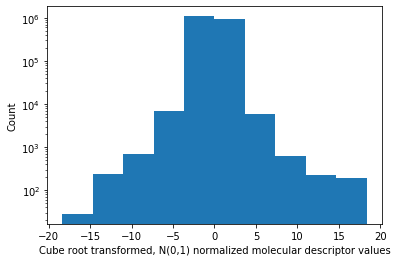

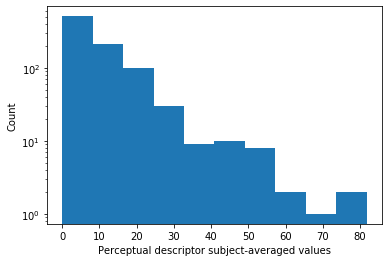

In [37]:
# Show the range of values for the molecular and perceptual descriptors.  
plt.hist(X_training.ravel())
plt.yscale('log')
plt.ylabel('Count')
plt.xlabel('Cube root transformed, N(0,1) normalized molecular descriptor values')
plt.figure()
plt.hist(Y_training_imp['mean_std'][:21].ravel())
plt.yscale('log')
plt.ylabel('Count')
plt.xlabel('Perceptual descriptor subject-averaged values')

## Fitting and Generating Submission Files

In [38]:
write = False # Set to True to actually generate the prediction files.  
n_estimators = 25 # Set this to a high number (e.g. 1000) to get a good fit.  

# Best parameters, determined independently.  
max_features = {'int':{'mean':None,'sigma':None},
                'ple':{'mean':100,'sigma':None},
                'dec':{'mean':500,'sigma':500}}
min_samples_leaf = {'int':{'mean':1,'sigma':4},
                'ple':{'mean':1,'sigma':1},
                'dec':{'mean':1,'sigma':1}}
max_depth = {'int':{'mean':None,'sigma':2},
                'ple':{'mean':10,'sigma':10},
                'dec':{'mean':10,'sigma':10}}
et = {'int':{'mean':True,'sigma':True},
                'ple':{'mean':False,'sigma':False},
                'dec':{'mean':False,'sigma':False}}
#et['int'] = {'mean':False,'sigma':False} # Uncomment to get a correct score estimate, or leave commented to get best fit.  
use_mask = {'int':{'mean':False,'sigma':True},
                'ple':{'mean':False,'sigma':True},
                'dec':{'mean':False,'sigma':True}}

In [39]:
rfcs_leaderboard,score,rs = fit2.rfc_final(X_training,Y_training_imp['mean_std'],Y_training_mask['mean_std'],
                            max_features,min_samples_leaf,max_depth,et,use_mask,
                            n_estimators=n_estimators)

For subchallenge 2:
	Score = 7.36
	int_mean = 1.000
	int_sigma = 0.151
	ple_mean = 0.599
	ple_sigma = 0.239
	dec_mean = 0.422
	dec_sigma = 0.330


In [40]:
type(rfcs_leaderboard)

dict

In [41]:
rfcs_leaderboard.keys()

dict_keys(['int', 'ple', 'dec'])

In [42]:
df_rfcs_leaderboard = pd.DataFrame(data = rfcs_leaderboard)
df_rfcs_leaderboard.to_csv('결과2/rfcs_leaderboard.csv')

In [44]:
_ = loading.make_prediction_files(rfcs_leaderboard,X_leaderboard_int,X_leaderboard_other,'leaderboard',2,write=False)

In [46]:
type(_)

dict

In [47]:
_.keys()

dict_keys(['subject', 'mean_std'])

In [45]:
df_rfcs_leaderboard_predictionresult = pd.DataFrame(data = _)
df_rfcs_leaderboard_predictionresult.to_csv('결과2/rfcs_leaderboard_predictionresult.csv')

Exception: Data must be 1-dimensional

In [ ]:
rfcs,score,rs = fit2.rfc_final(X_all,Y_all_imp['mean_std'],Y_all_mask['mean_std'],
                            max_features,min_samples_leaf,max_depth,et,use_mask,
                            n_estimators=n_estimators)

df_rfcs = pd.DataFrame(data = rfcs)
df_rfcs.to_csv('결과2/rfcs.csv')

In [ ]:
_ = loading.make_prediction_files(rfcs,X_testset_int,X_testset_other,'testset',2,write=False)

In [ ]:
df_rfcs_predictionresult = pd.DataFrame(data = _)
df_rfcs_predictionresult.to_csv('결과2/rfcs_predictionresult.csv')